# Walkthrough

**Zvec** is a *lightweight*, *high-performance*, *in-process*, *open-source* vector database built for developers who need fast and reliable similarity search.

You can use it as a *standalone vector database*, or embed it as a *vector search engine* inside your existing database systems.

Zvec handles indexing, filtering, and grouped queries out of the box — and supports dense and sparse vectors, multiple index strategies (like `HNSW` and `IVF`), quantization, and dynamic field schema — all through a clean Python API.

This notebook provides hands-on examples to help you integrate Zvec quickly and effectively.

- If you're new to vector search concepts — like embeddings, vector indexes, quantizations — please see the [Concepts](https://zvec.org/en/docs/concepts/) section in the documentation.
- For detailed API references, configuration options, and usage patterns, please visit the [Zvec documentation](https://zvec.org/en/docs/).

## Table of Contents

1. [Installation](#installation)
1. [Global Configuration](#global-configuration)
1. [Creating a Collection](#creating-a-collection)
1. [Inserting Data](#inserting-data)
1. [Querying with Vector Search](#querying-with-vector-search)
1. [Advanced Functionalities](#advanced-functionalities)
1. [Destroying a Collection](#destroying-a-collection)

## Installation

Zvec is available on [PyPI](https://pypi.org/project/zvec/) as a standard Python package. For most users, this is the fastest and simplest way to get started.

```python
# - In a Jupyter notebook: use `%pip` syntax to install into the current Python environment
# - In a terminal or regular Python script: just run `pip install` (without the `%`).
pip install zvec
```

In [1]:
%pip install zvec

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Once installed, verify that everything works:
import zvec

print("Zvec version: ", zvec.__version__)

Zvec version:  0.0.2.dev212+gc95ea0836


## Global Configuration

Before using Zvec, we configure it globally by setting the log type to `console` and the log level to `WARN`.  
This ensures that only important warnings (and more severe messages) are displayed in the notebook output, keeping things clean while still alerting you to potential issues.

In [3]:
# This should be run only once.
zvec.init(log_type=zvec.LogType.CONSOLE, log_level=zvec.LogLevel.WARN)

## Creating a Collection

In Zvec, data is organized into **collections** — logical containers that group related data and manage their own indexing and storage settings.

Think of a collection like a table in a relational database, but optimized for vector search and hybrid queries.

Every collection must be defined with an explicit **schema** that specifies:

1. `name`: An identifier for the collection.
1. `fields`: A list of scalar fields.
1. `vectors`: A list of vectors.

To create a collection, use the `create_and_open()` function with a `CollectionSchema`. 

If you'd like to dive deeper into the details, check out the [full documentation](https://zvec.org/en/docs/collections/create/). But feel free to skip it for now — you can follow along with this notebook just fine!


### Example: Create a Collection for Image Search

Let's create a collection named `image_search` with:
- A **scalar** field `base64_image`: used to display images
- A **vector** field `embedding`: used for similarity search

Here’s how you can define and create this collection:

In [4]:
# Define the scalar field using FieldSchema
image_encoding = zvec.FieldSchema(
    name="base64_image",
    data_type=zvec.DataType.STRING,  # String type
)

# Define the vector using VectorSchema
image_embedding = zvec.VectorSchema(
    name="embedding",
    data_type=zvec.DataType.VECTOR_FP32,  # Dense vector of float32 precision
    dimension=1024,  # Dimension of the embedding vectors
    # Use HNSW vector index with cosine similarity
    index_param=zvec.HnswIndexParam(metric_type=zvec.MetricType.COSINE),
)

# Define the collection schema
collection_schema = zvec.CollectionSchema(
    name="image_search",
    fields=[image_encoding],  # List of scalar fields (only one defined here for now)
    vectors=[image_embedding],  # List of vectors (only one defined here for now)
)

# Create the collection
collection = zvec.create_and_open(
    path="./image_search",  # Path to store the collection (feel free to change this)
    schema=collection_schema,
)

You should now see a new directory named **image_search** (or another name based on your configuration) created in your working directory.

> ⚠️ **Notes**:  
> - The `create_and_open()` function creates a **new** collection and will fail if the specified path already exists.  
        If you see an error like "path already exists", please delete the collection directory and restart notebook kernel to start fresh.
> - In Jupyter notebooks, it's easy to re-run cells — but `create_and_open()` only works the first time. On subsequent runs, the collection already exists, so the call will fail.
> - Use the `open()` function for loading existing collections.  
>       This tutorial focuses exclusively on starting fresh with a new, empty collection. We do **not** cover the `open()` function here — please refer to the [documentation](https://zvec.org/en/docs/collections/open/) for details.

We use an [HNSW index](https://zvec.org/en/docs/concepts/vector-index/hnsw-index/) to efficiently search over the `embedding` vectors.

**Always align your vector index settings (such as similarity metric and dimensionality) with those of your embedding model**.

In this example, we use cosine similarity and a 1024-dimensional vector index because the underlying embedding model was trained for cosine similarity and outputs 1024-dimensional vectors.  
For your own use case, follow the specifications of your chosen embedding model.

To view the collection schema:

In [5]:
print(collection.schema)

{
  "name": "image_search",
  "fields": {
    "base64_image": {
      "name": "base64_image",
      "data_type": "STRING",
      "nullable": false,
      "index_param": null
    }
  },
  "vectors": {
    "embedding": {
      "name": "embedding",
      "data_type": "VECTOR_FP32",
      "dimension": 1024,
      "index_param": {
        "type": "HNSW",
        "metric_type": "COSINE",
        "m": 100,
        "ef_construction": 500,
        "quantize_type": "UNDEFINED"
      }
    }
  }
}


For a detailed explanation of the schema format, please see the [documentation](https://zvec.org/en/docs/collections/inspect/#collection-schema).

To view the collection statistics:

In [6]:
print(collection.stats)
# Should show doc_count as 0 because the collection is empty now

{"doc_count":0, "index_completeness":{"embedding":1.000000}}


## Inserting Data

Once your collection is created, you can start inserting data.

In a typical use case, you start with **raw data** — such as images, text, or other unstructured content. The raw data is passed through an [embedding model](https://zvec.org/en/docs/concepts/vector-embedding/#what-is-an-embedding-model), which transforms it into a [vector embedding](https://zvec.org/en/docs/concepts/vector-embedding/). Alongside the embedding, you often store **scalar fields** (like categories, etc.) to support filtering, retrieval, or hybrid queries.

To keep this notebook *self-contained* and *easy to run*, we've pre-generated a small sample dataset in the **JSONL** format. The original images are taken from the [ImageNet-Val5k](https://modelscope.cn/datasets/iic/imagenet-val5k-image) dataset, and their embeddings were precomputed using the **Qwen2.5-VL-Embedding** multimodal model.

Each document in the **JSONL** file includes:

1. `id`: A unique identifier for the document.
1. `image_encoding`: A base64-encoded string representing the original image.
1. `image_embedding`: A precomputed vector embedding for the image.
1. `category`: An optional categorical label (e.g., `animal`, `vehicle`).

You'll load this ready-to-use data and insert it directly into your collection using the `insert()` method.

> Note: Before proceeding, you may need to install a few dependencies for handling the data.
> If you're running this notebook in a clean environment, run the cell below to ensure everything is set up.

In [7]:
%pip install Pillow
%pip install matplotlib

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


### Load and Inspect the Data

Now let’s load the sample data and take a quick look at its structure.

In [8]:
import walkthrough_utils

# Load the pre-generated sample data using provided utility
data = walkthrough_utils.load_jsonl("./data.jsonl")

The `data` is a list of dictionaries (`list[dict]`), each dict represents a single document with the following key-value pairs:

1. `id`
1. `image_encoding`
1. `image_embedding`
1. `category` (optional)

Inspect some samples:

Structure of the first document:  dict_keys(['id', 'image_encoding', 'image_embedding', 'category'])
Total number of documents loaded: 130

Displaying image[2] from the dataset:


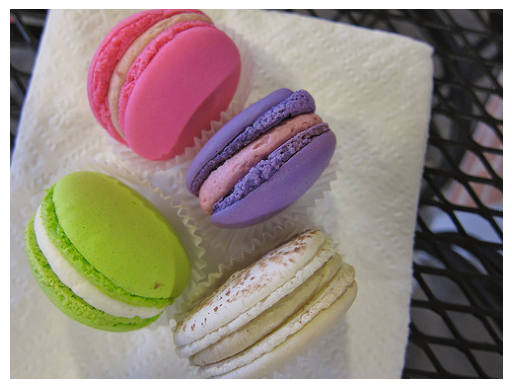

ID: ILSVRC2012_val_00000008
Dimension of the image embedding: 1024
Image embedding:  [-0.03562212735414505, -0.08828700333833694, -0.010896180756390095, -0.07767020910978317, -0.0011437496868893504, 0.026122894138097763, -0.0029859724454581738, -0.015506102703511715, 0.09778623282909393, 0.09610989689826965, 0.01382976770401001, -0.00942938681691885, -0.014458393678069115, 0.00398129690438509, 0.022909918799996376, 0.06453891843557358, 0.01299159973859787, 0.0251450315117836, 0.05923052132129669, -0.06872975081205368, -0.0251450315117836, 0.08437555283308029, 0.005937021691352129, -0.027380146086215973, -0.05280456691980362, -0.018719078972935677, -0.0419083870947361, 0.026961062103509903, 0.03827632591128349, -0.024027474224567413, 0.01508701965212822, -0.009569081477820873, -0.11119692027568817, -0.03464426472783089, 0.017322132363915443, 0.020395414903759956, -0.0057624033652246, -0.02724045142531395, -0.06733281165361404, 0.030453428626060486, -0.00820705946534872, -0.0022525757085

In [9]:
# Inspect the structure and size of the dataset
print("Structure of the first document: ", data[0].keys())
print(f"Total number of documents loaded: {len(data)}")

# Preview an example document (feel free to change index to explore others)
example_index = 2

# Get the raw document
raw_doc = data[example_index]
print(f"\nDisplaying image[{example_index}] from the dataset:")

# A provided utility function to display an image from a base64 string
walkthrough_utils.display_image_from_base64(raw_doc["image_encoding"])
print(f"ID: {raw_doc['id']}")
print(f"Dimension of the image embedding: {len(raw_doc['image_embedding'])}")
print("Image embedding: ", raw_doc["image_embedding"])
if "category" in raw_doc:
    print("Category: ", raw_doc["category"])

> ⚠️ **Note**:  
> - The `image_encoding` field contains a base64-encoded string of the image, which is extremely long and not human-readable — so we don't print it directly.  
        Instead, we use a helper function `display_image_from_base64()` to render the actual image.
> - The `image_embedding` is a 1024-dimensional vector. Printing it shows a very long **list of floats**, which isn't particularly informative on its own — but we include a snippet here for completeness.  
        In practice, you'll usually work with these embeddings programmatically (e.g., for similarity search), not by reading them visually.

### Insert Data into Collection

Now that we've loaded and inspected our sample data, the next step is to insert it into our collection.

This involves converting each raw record into a `Doc` object and then using the `insert()` method to add these documents to the collection.

A `Doc` represents a single [document](https://zvec.org/en/docs/concepts/data-modeling/#documents) in the collection and consists of three main components:

1. `id`: A unique identifier for the document.
1. `fields`: A dictionary of named scalar (non-vector) fields.
1. `vectors`: A dictionary of named vector embeddings.

Both `fields` and `vectors` use a dictionary structure — each key corresponds to the name of a field or vector as defined in the collection's schema, and each value holds the actual data.

This design allows you to include multiple fields or vectors in a single document. The key-value pairs you provide must **conform to the schema** specified when the collection was created.

In this simple example, the collection schema defines only one scalar field (`base64_image`, of type string) and one vector (`embedding`, a list of floats), so our documents contain just those two entries.

In [10]:
# Iterate over each raw document in the dataset
for raw_doc in data:
    # Create a new Doc instance using the id, base64-encoded image, and image embedding from the raw document
    id: str = raw_doc["id"]  # A string
    image: str = raw_doc["image_encoding"]  # A string
    vector: list[float] = raw_doc["image_embedding"]  # A list of floats
    doc = zvec.Doc(
        id=id,
        fields={
            "base64_image": image,
        },
        vectors={
            "embedding": vector,
        },
    )
    # Insert the newly created document into the collection
    result = collection.insert(doc)
    # Check if the insertion was successful
    if not result.ok():
        print(result)
        break

> ⚠️ **Notes**:  
> The code snippet above performs [**insertion**](https://zvec.org/en/docs/data-operations/insert/), not [upsert](https://zvec.org/en/docs/data-operations/upsert/). That means if a document with the same id already exists in the collection, the operation will fail.
>
> If you see an error message like `doc_id[*] already exists in collection`, don't panic! This simply means the document (or a document with that `id`) has already been inserted into the collection.  
        It's a common occurrence during development or when re-running ingestion scripts.

### View Collection Statistics Again

Let's check the collection statistics once more. This time, you should see that the collection contains **130** documents — matching the total number of records in the dataset.

You might notice that the `index_completeness` is 0. This means the HNSW index **has not yet been built** for these documents.  
Until indexing completes, vector search will fall back to brute-force search — which is slower but still functional. But don't worry about this for now; we'll cover it in more detail later!

In [11]:
print(collection.stats)

{"doc_count":130, "index_completeness":{"embedding":0.000000}}


## Querying with Vector Search

Now that our data has been successfully inserted into the collection, we can perform **vector similarity searches** to retrieve semantically relevant results.

The image embeddings in our collection were generated using the **Qwen2.5-VL-Embedding** model.  
Since this model is **multimodal**, it produces embeddings in a shared semantic space for both images and text — meaning you can use either an *image* or a *text description* as your query.

To keep this notebook **self-contained** and **easy to run**, we've precomputed embeddings for several example queries and saved them in **JSONL** files.

We'll load these precomputed query vectors and use them directly for our search — but if you're curious or want to explore further, feel free to try your own queries by generating embeddings with the **Qwen2.5-VL-Embedding** model.

### Text Query

Let's start with a **text query**.

For example, to find images of "cute dog", we would normally:

1. Encode the phrase into a vector using the **Qwen2.5-VL-Embedding** model, then
1. Perform a vector search against the collection.

In this notebook, we'll skip the encoding step and use the precomputed embedding instead.

Here's how we load the pregenerated text queries. Each entry is a dictionary containing:

- `text`: the original query string
- `embedding`: its corresponding vector representation

In [12]:
# Load the pre-generated text queries using provided utility
text_queries = walkthrough_utils.load_jsonl("./text_queries.jsonl")

# Inspect the text queries
print(f"Total number of text queries loaded: {len(text_queries)}")
print("Structure of the first text query: ", text_queries[0].keys())

# Inspect the first text query
query_index = 0  # Feel free to change the index to inspect different queries
print(f"\nThe text query at index {query_index} is:")
print(f"Text: {text_queries[query_index]['text']}")
print("Embedding: ", text_queries[query_index]["embedding"])

Total number of text queries loaded: 17
Structure of the first text query:  dict_keys(['text', 'embedding'])

The text query at index 0 is:
Text: Cute dog
Embedding:  [0.021464549005031586, 0.06730174273252487, -0.11687792837619781, -0.05733111500740051, 0.10136806219816208, -0.005608478561043739, -0.039882514625787735, 0.033927835524082184, 0.032958466559648514, 0.004916073754429817, 0.004050568211823702, 0.05733111500740051, 0.08087287843227386, -0.02631138265132904, 0.08530426770448685, -0.04985314607620239, 0.10081413388252258, -0.007408731151372194, 0.04265213385224342, 0.03655897453427315, 0.05871592462062836, 0.01911037229001522, 0.017448600381612778, 0.008447338826954365, -0.024372648447752, -0.04154428839683533, 0.1190936267375946, 0.09361312538385391, 0.00920898374170065, -0.03794378042221069, 0.044590868055820465, 0.015232905745506287, -0.023541763424873352, -0.04902225732803345, -0.02506505325436592, 0.04126732423901558, 0.05788503959774971, 0.005469997879117727, -0.0409903

The first text query is **"Cute dog"** — let's use it to perform a **vector similarity search** in our collection:

The first text query: Cute dog

Query result:

[{
  "id": "ILSVRC2012_val_00000949",
  "score": 0.6050288677215576,
  "fields": {
    "base64_image": ""
  },
  "vectors": {}
}, {
  "id": "ILSVRC2012_val_00000044",
  "score": 0.6827870607376099,
  "fields": {
    "base64_image": ""
  },
  "vectors": {}
}, {
  "id": "ILSVRC2012_val_00000003",
  "score": 0.6863648891448975,
  "fields": {
    "base64_image": ""
  },
  "vectors": {}
}]

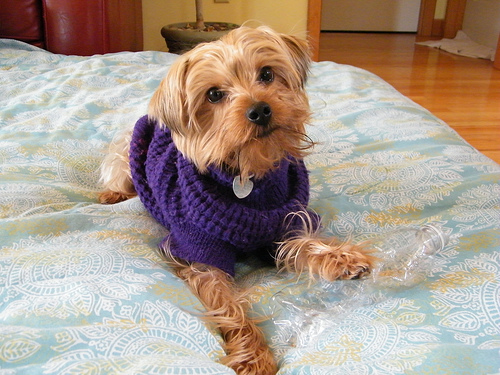
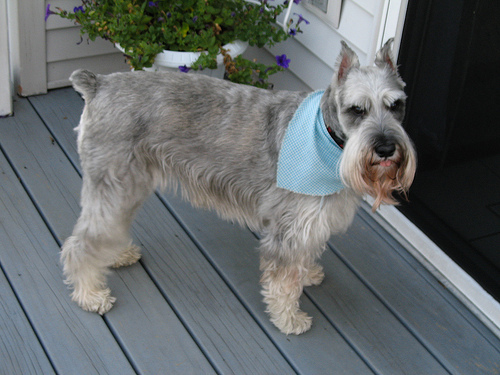
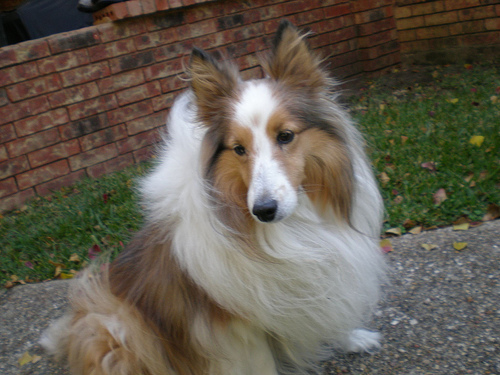

In [13]:
print(f"The first text query: {text_queries[0]['text']}")

result = collection.query(
    zvec.VectorQuery(
        field_name="embedding",  # The vector field in the collection to compare against
        vector=text_queries[0]["embedding"],  # Embedding of the "cute dogs" query
    ),
    topk=3,  # Retrieve the 3 most similar images
    include_vector=False,  # Skip returning the full vector to reduce payload size
)

print("\nQuery result:\n")
print(result)

We've now retrieved the top-3 most relevant documents for the query **"Cute dog"**.

The returned `result` is a list of `Doc` objects, where each `Doc` contains:

- `id`: The unique identifier of the document (the one we provided when inserting the document).
- `fields`: A dictionary of field names and their values. In our case, this includes the `base64_image` string.
- `vectors`: A dictionary of vector names and their values. This is currently empty because we did not specify `include_vector=True` when running the query.

Since raw base64 strings aren't human-readable, let's decode and display the actual images.  
By iterating through the `result` list, we can conveniently display each image along with its corresponding `id`.


Displaying image #1 with ID: ILSVRC2012_val_00000949


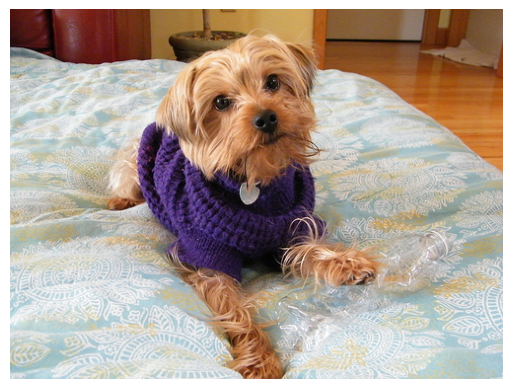


Displaying image #2 with ID: ILSVRC2012_val_00000044


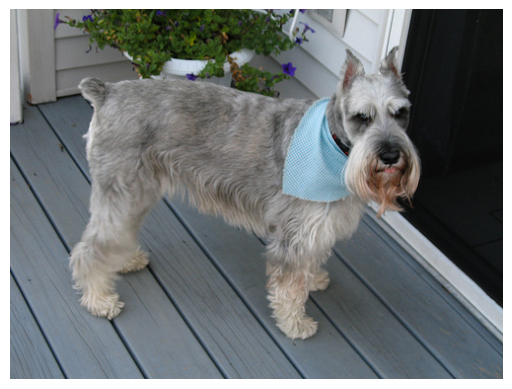


Displaying image #3 with ID: ILSVRC2012_val_00000003


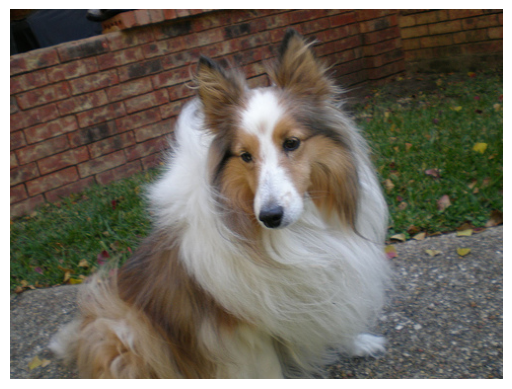

In [14]:
# Use the provided utility function to display each image from its base64 string
for idx, doc in enumerate(result):
    print(f"\nDisplaying image #{idx + 1} with ID: {doc.id}")
    walkthrough_utils.display_image_from_base64(doc.fields["base64_image"])

Aww — looks like we've got some adorable matches! 🐾 🐶

Let's explore more text queries by defining a helper function that runs a query and displays the top-3 most similar images.

In [15]:
def display_similar_images_by_text_query(query_index: int):
    text_query = text_queries[query_index]
    # Print the text query being used
    print(f"The text query[{query_index}]: {text_query['text']}")
    # Perform the vector similarity search
    result = collection.query(
        zvec.VectorQuery(
            field_name="embedding",  # The vector field in the collection to compare against
            vector=text_query["embedding"],  # Text embedding
        ),
        topk=3,  # Retrieve the 3 most similar images
        include_vector=False,  # Skip returning the full vector to reduce payload size
    )
    # Display the retrieved images
    for idx, doc in enumerate(result):
        print(f"\nDisplaying image #{idx + 1} with ID: {doc.id}")
        walkthrough_utils.display_image_from_base64(doc.fields["base64_image"])

Now, let's try the second query: **"Find images that have both a dog and a car."**

The text query[1]: Find images that have both a dog and a car.

Displaying image #1 with ID: ILSVRC2012_val_00000352


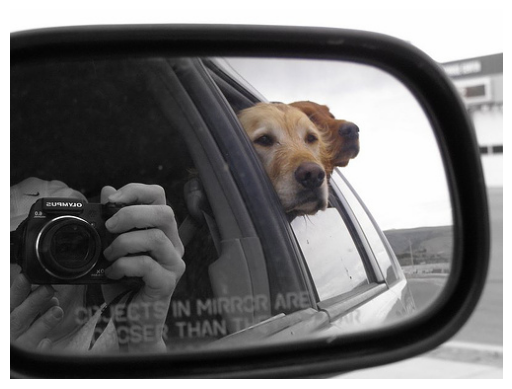


Displaying image #2 with ID: ILSVRC2012_val_00001269


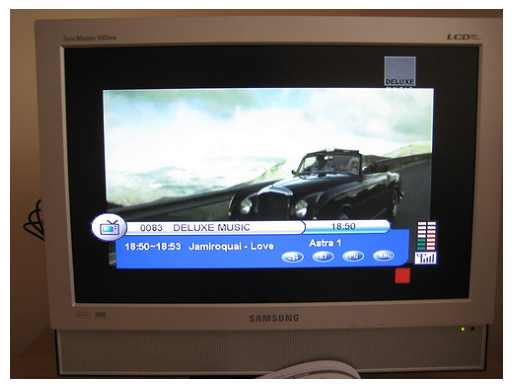


Displaying image #3 with ID: ILSVRC2012_val_00000028


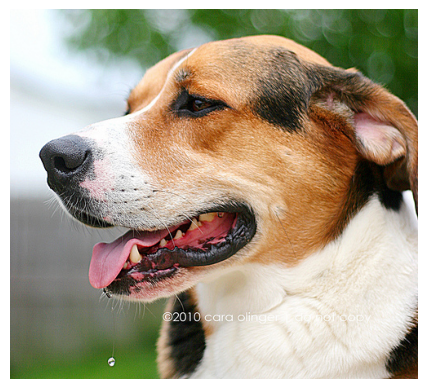

In [16]:
# Feel free to change the query_index to explore other queries
display_similar_images_by_text_query(query_index=1)

💡 **Note**:

You might notice that the second and third images don't perfectly fit the description.  
This discrepancy arises because our dataset is **too small**, and there is **only one image that contains both a dog and a car**.  
The other images, while not perfectly matching the query, still exhibit some connections to the semantic meaning of the query.

Feel free to experiment with other queries! Enjoy exploring! 🌄🚗🐕

Keep in mind that the **top-1** image should closely match the text query, whereas the following images might be somewhat off-topic due to the limited size of our database. However, you should still observe some thematic or contextual connections between the images and the query.

> ✅ In real production scenarios, where databases often contain millions or billions of items, vector similarity searches become much more precise and relevant.

### Image Query

So far, we've used text to search for images. Now it's time to try out **images as queries**!

We've precomputed embeddings for several example query images and saved them in a **JSONL** file. Each entry includes:

- `encoding`: a base64-encoded string representing the original image
- `embedding`: its corresponding vector representation

Let's load these image queries and try one out!

In [17]:
# Load the pre-generated image queries using the provided utility
image_queries: list[dict] = walkthrough_utils.load_jsonl("./image_queries.jsonl")

print(f"Loaded {len(image_queries)} image queries.")


# Define a helper function to display the query image and retrieves
# similar images from the collection
def display_similar_images_by_image_query(query_index: int):
    image_query = image_queries[query_index]
    # Display the image being queried
    print(f"The image query[{query_index}]:")
    walkthrough_utils.display_image_from_base64(image_query["encoding"])
    # Perform the vector similarity search
    result = collection.query(
        zvec.VectorQuery(
            field_name="embedding",  # The vector field in the collection to compare against
            vector=image_query["embedding"],  # Image embedding
        ),
        topk=3,  # Retrieve the 3 most similar images
        include_vector=False,  # Skip returning the full vector to reduce payload size
    )
    # Display the retrieved images
    print(f"\nRetrieved {len(result)} similar images:")
    for idx, doc in enumerate(result):
        print(f"\nDisplaying image #{idx + 1} with ID: {doc.id}")
        walkthrough_utils.display_image_from_base64(doc.fields["base64_image"])

Loaded 6 image queries.


> 💡 **Note**: Feel free to change the `query_index` to explore different image queries.  
> The **top-1** image should closely match the text query, whereas the following images might be somewhat off-topic due to the limited size of our database.

The image query[0]:


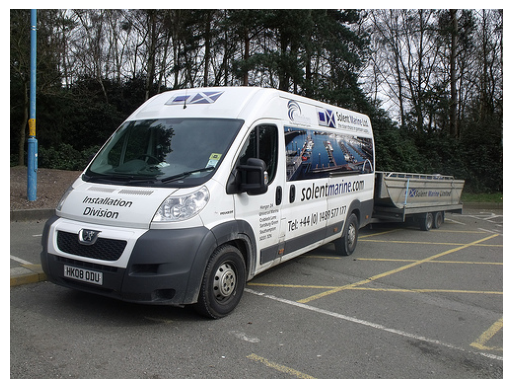


Retrieved 3 similar images:

Displaying image #1 with ID: ILSVRC2012_val_00000014


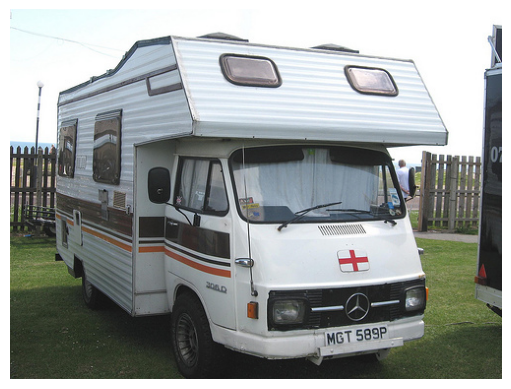


Displaying image #2 with ID: ILSVRC2012_val_00000434


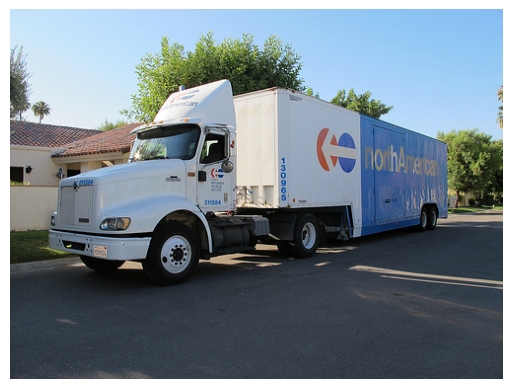


Displaying image #3 with ID: ILSVRC2012_val_00000314


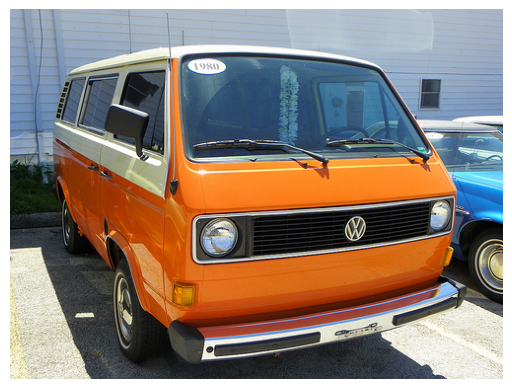

In [18]:
# Feel free to change the query_index
display_similar_images_by_image_query(0)

## Advanced Functionalities

This walkthrough has covered the fundamentals of creating and querying a vector collection. Zvec, however, offers a range of advanced capabilities to support more complex use cases:

- **Filtered vector queries**
- **Hybrid dense and sparse vectors support**
- **Multiple scalar fields and vector embeddings per document**
- **Various index types and flexible indexing strategies**

For in-depth guidance on these features, including configuration options and performance tips, please refer to the [official documentation](https://zvec.org/en/docs/).

## Destroying a Collection

When you're finished experimenting — or if a collection is no longer needed — you can permanently delete it to free up storage.

Zvec provides a simple but **irreversible** method for this:

```python
collection.destroy()
```

This operation **deletes all data** associated with the collection. Once deleted, the collection cannot be recovered.

> ⚠️ Warning: `destroy()` is permanent. Double-check that you no longer need the data before calling this method.

In [19]:
# Permanently delete
collection.destroy()

print("✅ Collection deleted successfully.")

✅ Collection deleted successfully.
